In [12]:
!pip install pyvi --quiet

In [13]:
# Load libray
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec
import gensim
from pyvi import ViTokenizer
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [14]:
# Load dataset
test_data = pd.read_csv('https://raw.githubusercontent.com/trantrieuvi/AI_Project_Sentiment_Analysis/main/data/Sentiment_TestData.csv')
train_data = pd.read_csv('https://raw.githubusercontent.com/trantrieuvi/AI_Project_Sentiment_Analysis/main/data/Sentiment_TrainData.csv')

In [15]:
train_data[train_data['label']==1].count

<bound method DataFrame.count of Empty DataFrame
Columns: [Unnamed: 0, index, comment, n_star, date_time, label]
Index: []>

In [16]:
# Data labeling function
def create_label(main_data):
  conditions = [
    (main_data['n_star'] <= 3),
    (main_data['n_star'] >=4),
    ]
  values = [0, 1]
  main_data['label'] = np.select(conditions, values)
  main_data =  main_data[['index','comment','label']]
  return main_data

In [17]:
# Labeling data
train_data =  create_label(train_data)
train_data

,index,comment,label
0,0,Mới mua máy này Tại thegioididong thốt nốt cảm...,1
1,1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,1
2,2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,0
3,3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",0
4,4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",1
...,...,...,...
10005,10005,"Mẫu mã đẹp lung linh. Máy chạy cực nhanh, mượt...",1
10006,10006,Có ai bị giống mình không máy thì sài bình thư...,1
10007,10007,Sản phẩm tốt 😊\nAi chơi game cứ mang 1 em về m...,1
10008,10008,Vừa mới mua xong máy rất đẹp nhân viên rất nhi...,1


# **Description of data**

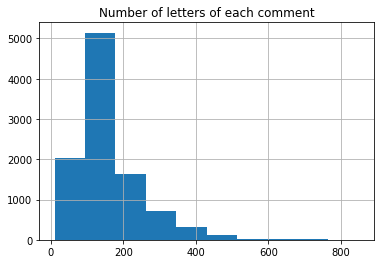

In [18]:
# Show histogram of number of letters of each comment
train_data['comment'].str.len().hist()
plt.title("Number of letters of each comment")
plt.show()

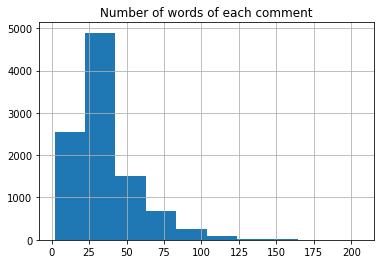

In [19]:
# Show histogram of number of words of each comment
train_data['comment'].str.split().map(lambda x: len(x)).hist()
plt.title("Number of words of each comment")
plt.show()

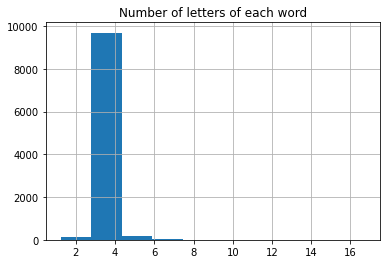

In [20]:
# Show histogram of number of letters of each word
train_data['comment'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()
plt.title("Number of letters of each word")
plt.show()

In [21]:
# Show number of each sentiment comment
pos = train_data[train_data['label']==1].count()
neg = train_data[train_data['label']==0].count()
print('Number of Positive comment: ', pos)
print('Number of Negative comment: ',neg)

Number of Positive comment:  index      6333
comment    6333
label      6333
dtype: int64
Number of Negative comment:  index      3677
comment    3677
label      3677
dtype: int64


# **Preporcessing data**

In [22]:
# Load file containing acronyms for the word: 'khong'
file = open('not.txt', 'r', encoding="utf8")
not_lst = file.read().split('\n')
file.close()

In [23]:
# Standardize acronyms for the word: 'khong'
def process_special_word(text):
    for khong in not_lst:
      new_text = ''
      text_lst = text.split()
      i= 0
      if khong in text_lst:
          while i <= len(text_lst) - 1:
              word = text_lst[i]
              if  word == khong:
                  next_idx = i+1
                  if next_idx <= len(text_lst) -1:
                      word = word +'_'+ text_lst[next_idx]
                  i= next_idx + 1
              else:
                  i = i+1
              new_text = new_text + word + ' '
      else:
          new_text = text
      text=new_text
    return new_text.strip()

In [24]:
# Data preprocessing function
def preprocess_data(data):
  # Renove Na/Nul values
  data = data.dropna(axis = 0,subset=['comment'])
  return data

In [25]:
# Comment preprocessor function in data
def preprocessing_text(text):
  # Remove special character
  text = text.str.replace('[^\w\s]','')
  # Remove digit
  text = text.replace('\d', '', regex=True)
  # Standardize acronyms for the word: 'khong'
  text = [process_special_word(i) for i in text]
  return text

In [26]:
# preprocessing trai data, test data
  # Train data
train_data = preprocess_data(train_data)
train_data['comment'] = preprocessing_text(train_data['comment'])
  # Test data
test_data = preprocess_data(test_data)
test_data['comment'] = preprocessing_text(test_data['comment'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [27]:
# Create comments, labels
comments, labels = train_data.comment, train_data.label

In [28]:
# Data normalization and word separation
input_gensim = []
for comment in comments:
    comment = gensim.utils.simple_preprocess(comment)
    comment = ' '.join(comment)
    comment = comment.lower()
    comment = ViTokenizer.tokenize(comment)
    input_gensim.append(comment.split())

In [29]:
# Define constant variables
max_seq = 100 # Maximum word count for a comment
embedding_size = 128 # Dimensions of embedding
sequence_length = 100
num_classes = 2
filter_sizes = 3
num_filters = 150
epochs = 20
batch_size = 30
learning_rate = 0.001
dropout_rate = 0.5

In [30]:
# Build and save Word2vec model 
model = Word2Vec(input_gensim, size=embedding_size, window=5, min_count=0, workers=4, sg=1)
model.wv.save("wordgensim.model")

In [31]:
model.wv.most_similar("xấu")

[('ảo', 0.9292659759521484),
 ('không_đẹp', 0.9251585006713867),
 ('nhạt', 0.9216580390930176),
 ('mờ', 0.9141855239868164),
 ('bệt', 0.9063290953636169),
 ('không_nét', 0.9054901599884033),
 ('zoom', 0.9002642631530762),
 ('k_đẹp', 0.9000853300094604),
 ('selfie', 0.8970164060592651),
 ('vỡ', 0.8947378396987915)]

In [32]:
model_embedding = word2vec.KeyedVectors.load('wordgensim.model')
word_labels = []
for word in model_embedding.vocab.keys():
    word_labels.append(word)

In [33]:
# Embedding word into matrix function
def comment_embedding(comment):
    matrix = np.zeros((max_seq, embedding_size))
    words = comment.split()
    lencmt = len(words)
    n_cau = 0
    for i in range(max_seq):
        indexword = i % lencmt
        n_cau = i//lencmt
        if (max_seq - n_cau*lencmt < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = model_embedding[words[indexword]]
    matrix = np.array(matrix)
    return matrix

In [34]:
feedback = 'Đã chuyển từ XS Mã qua, do ko phải là OLED nên cũng rất ít tốn pin.'
print(comment_embedding(feedback))
print('Kích thước của vector đánh giá:\t',comment_embedding(feedback).shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02087034  0.16751839 -0.1094531  ... -0.18952724 -0.22287479
  -0.42202166]
 [ 0.31799498 -0.04284659 -0.02188162 ... -0.13209233 -0.01170299
  -0.18636236]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Kích thước của vector đánh giá:	 (100, 128)


In [35]:
# Processing and embedding data
train_data = []
for x in tqdm(comments):
    x = gensim.utils.simple_preprocess(x)
    x = ' '.join(x)
    x = ViTokenizer.tokenize(x)
    train_data.append(comment_embedding(x))
train_data = np.array(train_data)
train_data.shape

100%|██████████| 10010/10010 [00:33<00:00, 297.53it/s]


(10010, 100, 128)

# **Training Model**

In [36]:
# Processing data for training
x_train = train_data.reshape(train_data.shape[0], sequence_length, embedding_size, 1).astype('float32')
y_train = np.array(labels)

In [37]:
# Building CNN model
model = keras.Sequential()
model.add(layers.Convolution2D(num_filters, (filter_sizes, embedding_size),
                               padding='valid',
                               input_shape=(sequence_length, embedding_size, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(68, 1)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 1, 150)        57750     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 150)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 150)         0         
                                                                 
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 128)               19328     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [38]:
# Training model
history = model.fit(x = x_train[:9000], y = y_train[:9000], batch_size = batch_size, verbose=1, epochs=epochs, validation_data=(x_train[9000:10010],y_train[9000:10010]))

Epoch 1/20
300/300 [==============================] - 8s 24ms/step - loss: 0.4239 - accuracy: 0.8047 - val_loss: 0.3512 - val_accuracy: 0.8436
Epoch 2/20
300/300 [==============================] - 7s 24ms/step - loss: 0.3659 - accuracy: 0.8417 - val_loss: 0.3320 - val_accuracy: 0.8495
Epoch 3/20
300/300 [==============================] - 7s 24ms/step - loss: 0.3543 - accuracy: 0.8441 - val_loss: 0.3379 - val_accuracy: 0.8485
Epoch 4/20
300/300 [==============================] - 7s 24ms/step - loss: 0.3381 - accuracy: 0.8497 - val_loss: 0.3255 - val_accuracy: 0.8515
Epoch 5/20
300/300 [==============================] - 7s 23ms/step - loss: 0.3329 - accuracy: 0.8512 - val_loss: 0.3627 - val_accuracy: 0.8465
Epoch 6/20
300/300 [==============================] - 7s 23ms/step - loss: 0.3289 - accuracy: 0.8570 - val_loss: 0.3172 - val_accuracy: 0.8545
Epoch 7/20
300/300 [==============================] - 7s 23ms/step - loss: 0.3155 - accuracy: 0.8624 - val_loss: 0.3135 - val_accuracy: 0.8604

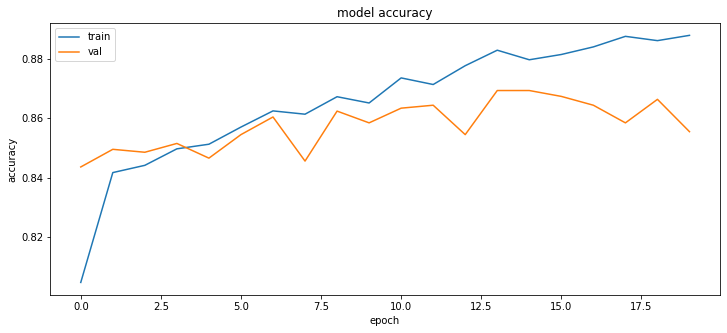

In [39]:
plt.figure(figsize=(12,5))
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


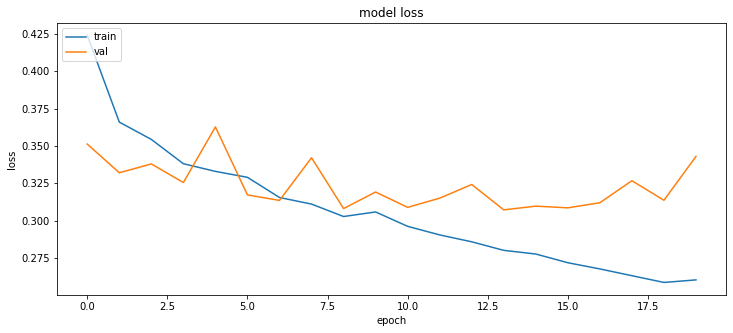

In [40]:
# summarize history for loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
# Save model
model.save('model.h5')

In [42]:
# Load model
model_sentiment = tf.keras.models.load_model('model.h5')

# **Predict**

In [43]:
# Predict function
def predict(comment):
    comment = process_special_word(comment)
    comment = ''.join( c for c in comment if  c not in '?:!/;#,1234567890.' )
    
    comment = gensim.utils.simple_preprocess(comment)
    comment = ' '.join(comment)
    comment = ViTokenizer.tokenize(comment)

    maxtrix_embedding = np.expand_dims(comment_embedding(comment), axis=0)
    maxtrix_embedding = np.expand_dims(maxtrix_embedding, axis=3)
    
    result = model_sentiment.predict(maxtrix_embedding)

    max_index = np.round(result)
    result = float(result)
    result = np.round(result,2)
    if max_index == 0: print("Tiêu cực")
    if max_index == 1: print("Tích cực")
    
    print(result)

In [44]:
predict('pin yếu nhưng máy đẹp')

Tích cực
0.73


In [45]:
predict('máy này chơi game không được')

Tiêu cực
0.41


In [46]:
predict('máy bắt wifi chưa được tốt cho lắm')

Tiêu cực
0.33
